In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import cluster as skc
import sklearn as skl
import sklearn.preprocessing
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from scipy import cluster as skc
import sklearn as skl
import sklearn.preprocessing



In [54]:
#reading Dataset
ngo= pd.read_csv("Country-data.csv")
ngo.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [55]:
#Sanity Check
ngo.shape
ngo.describe()
ngo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [56]:
#Na Handling
ngo.isnull().values.any()
ngo.isnull().values.sum()
ngo.isnull().sum()*100/ngo.shape[0]

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [57]:
# Checking for outliers in the continuous variables
num_ngo = ngo[['child_mort','health','income','life_expec','gdpp']]

In [58]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
num_ngo.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,health,income,life_expec,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,6.815689,17144.688623,70.555689,12964.155689
std,40.328931,2.746837,19278.067698,8.893172,18328.704809
min,2.600000,1.810000,609.000000,32.100000,231.000000
25%,8.250000,4.920000,3355.000000,65.300000,1330.000000
50%,19.300000,6.320000,9960.000000,73.100000,4660.000000
75%,62.100000,8.600000,22800.000000,76.800000,14050.000000
90%,100.220000,10.940000,41220.000000,80.400000,41840.000000
95%,116.000000,11.570000,48290.000000,81.400000,48610.000000
99%,153.400000,13.474000,84374.000000,82.370000,79088.000000


In [ ]:
#From the distribution shown above, we can see that there no outliner in the data. The numbers are gradually increasing.

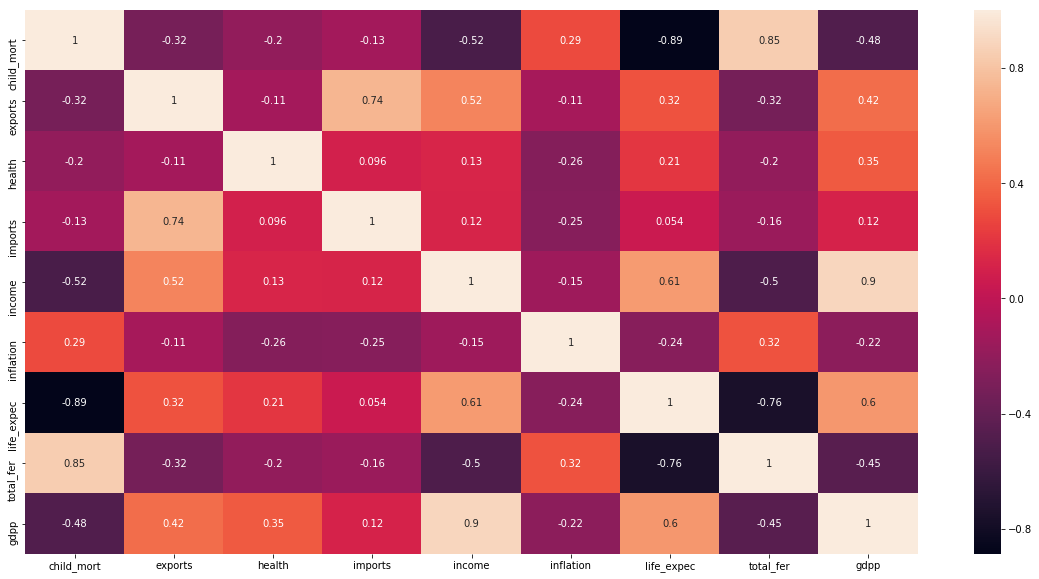

In [8]:
# Let's see the correlation matrix
ngo1=ngo[['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']]
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(ngo1.corr(),annot = True)

In [ ]:
#Hitmap shows strong coorelation between Income & GDPP & child_mort & total_fer.
#For ease of analysis, I have chosen only the numerical variables because we cannot do clustering or PCA with categorical variables.
#Now, that we have selected the data we need to standardize the data. We will standardize the data by defining a function for standardization.

In [9]:
## Standardize the variables.
def standardization_f(ngo1):
    x_bar = np.mean(ngo1)
    s = np.std(ngo1)
    x_z = (ngo1 - x_bar) / s
    return(x_z)
print(ngo1.corr())
x_z = ngo1.apply(standardization_f, broadcast = True)
x_z.head()

            child_mort   exports    health   imports    income  inflation  \
child_mort    1.000000 -0.318093 -0.200402 -0.127211 -0.524315   0.288276   
exports      -0.318093  1.000000 -0.114408  0.737381  0.516784  -0.107294   
health       -0.200402 -0.114408  1.000000  0.095717  0.129579  -0.255376   
imports      -0.127211  0.737381  0.095717  1.000000  0.122406  -0.246994   
income       -0.524315  0.516784  0.129579  0.122406  1.000000  -0.147756   
inflation     0.288276 -0.107294 -0.255376 -0.246994 -0.147756   1.000000   
life_expec   -0.886676  0.316313  0.210692  0.054391  0.611962  -0.239705   
total_fer     0.848478 -0.320011 -0.196674 -0.159048 -0.501840   0.316921   
gdpp         -0.483032  0.418725  0.345966  0.115498  0.895571  -0.221631   

            life_expec  total_fer      gdpp  
child_mort   -0.886676   0.848478 -0.483032  
exports       0.316313  -0.320011  0.418725  
health        0.210692  -0.196674  0.345966  
imports       0.054391  -0.159048  0.115498  

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


In [10]:
#In k-means clustering, we come up with number of clusters we would like to see. Then after plotting a scatter plot, we see if the number of clusters are appropriate or not.
#Here, we will start by asking the algorithm to assign three clusters and see how it fits the data.
# perform K means clustering on x_z or standardized data
import scipy
from scipy.cluster.vq import vq, kmeans, whiten
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

#changing x_z from dataframe to an array
x_z1 = np.array(x_z)

##kmeans clustering for 3 clusters
kmeans_x,_ = kmeans(x_z1,3)
print(kmeans_x)

[[-0.43706491  0.02737909 -0.19090588  0.06955093 -0.20131886 -0.03918493
   0.28566125 -0.44720856 -0.31752579]
 [ 1.34541883 -0.45967186 -0.1895969  -0.22567743 -0.68713515  0.39226703
  -1.26429235  1.32908188 -0.60530769]
 [-0.82985801  0.6150709   0.80342073  0.14942456  1.57803837 -0.48186651
   1.11979699 -0.77777456  1.77123477]]


In [11]:
# assign each sample to a cluster
idx3,_ = vq(x_z1,kmeans_x)

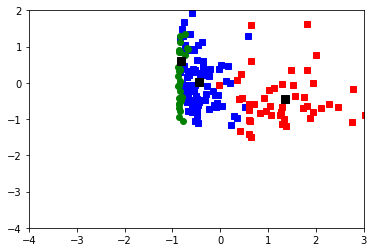

In [12]:
# plot a scatterplot
plt.plot(x_z1[idx3==0,0],x_z1[idx3==0,1],'sb',
     x_z1[idx3==1,0],x_z1[idx3==1,1],'sr',
     x_z1[idx3==2,0],x_z1[idx3==2,1],'og')
plt.plot(kmeans_x[:,0],kmeans_x[:,1],'sk',markersize=8)
plt.xlim(-4.0, 3.0)
plt.ylim(-4.0, 2.0)
show()

In [13]:
#Each color represents a cluster. We can see more or less clean separation in blue and red but slightly more overlap in blue and green.
#Now lets try asking the algorithm for four clusters and observe it in a scatterplot.
##kmeans clustering for 4 clusters
kmeans_x4,_ = kmeans(x_z1,4)


In [14]:
# assign each sample to a cluster
idx4,_ = vq(x_z1,kmeans_x4)



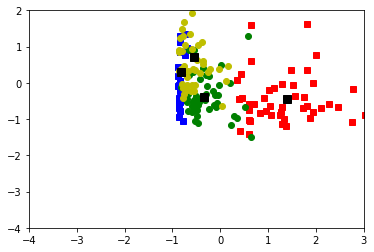

In [15]:
# Plot a scatterplot
plt.plot(x_z1[idx4==0,0],x_z1[idx4==0,1],'sb',
     x_z1[idx4==1,0],x_z1[idx4==1,1],'sr',
     x_z1[idx4==2,0],x_z1[idx4==2,1],'og',
     x_z1[idx4==3,0],x_z1[idx4==3,1],'oy')
plt.plot(kmeans_x4[:,0],kmeans_x4[:,1],'sk',markersize=8)
plt.xlim(-4.0, 3.0)
plt.ylim(-4.0, 2.0)
show()

In [16]:
#Four clusters look worse than three. Now, lets try two clusters only.
##kmeans clustering for 2 clusters
kmeans_x2,_ = kmeans(x_z1,2)


In [17]:
# assign each sample to a cluster
idx2,_ = vq(x_z1,kmeans_x2)


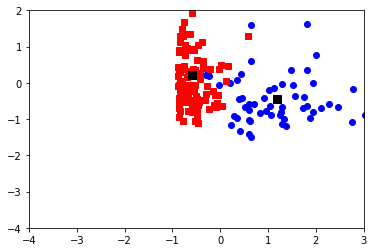

In [18]:
# Plot a scatterplot
plt.plot(x_z1[idx2==0,0],x_z1[idx2==0,1],'ob',
     x_z1[idx2==1,0],x_z1[idx2==1,1],'sr')
plt.plot(kmeans_x2[:,0],kmeans_x2[:,1],'sk',markersize=8)
plt.xlim(-4.0, 3.0)
plt.ylim(-4.0, 2.0)
show()

In [ ]:
#We conducted K-means clustering using K = 2, 3, and 4. We think K = 3 gives the best discrimination based on scatter plots observed above.

In [19]:
#Silhouette Analysis
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(x_z)
    sse_.append([k, silhouette_score(x_z, kmeans.labels_)])

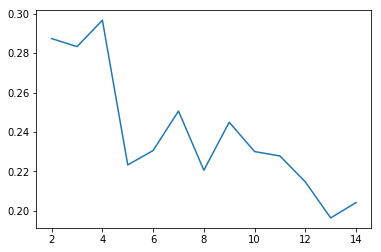

In [20]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

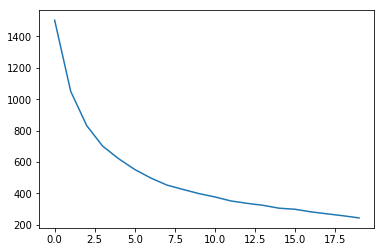

In [21]:
#Sum of Squared Distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(x_z)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [22]:
#Principal Component Analysis
## Compute covariance matrix of standardized variables.
RR = x_z.cov()
RR.head(6)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.006024,-0.320009,-0.201609,-0.127977,-0.527474,0.290013,-0.892018,0.853589,-0.485942
exports,-0.320009,1.006024,-0.115098,0.741823,0.519897,-0.107941,0.318218,-0.321938,0.421247
health,-0.201609,-0.115098,1.006024,0.096293,0.130359,-0.256914,0.211961,-0.197859,0.348050
imports,-0.127977,0.741823,0.096293,1.006024,0.123144,-0.248482,0.054718,-0.160007,0.116194
income,-0.527474,0.519897,0.130359,0.123144,1.006024,-0.148646,0.615649,-0.504863,0.900966
inflation,0.290013,-0.107941,-0.256914,-0.248482,-0.148646,1.006024,-0.241149,0.318830,-0.222966


In [23]:
## Compute eigenvalues and eigenvectors of covariance matrix. 
eigen_RR = np.linalg.eig(RR)
print(eigen_RR[0])
print(eigen_RR[1])

[4.16057017 1.55566165 1.1774338  1.00077724 0.66459866 0.224928
 0.06727787 0.08884738 0.1141221 ]
[[ 0.41951945 -0.19288394  0.02954353 -0.37065326 -0.16896968 -0.20062815
  -0.3275418  -0.68274306 -0.07948854]
 [-0.28389698 -0.61316349 -0.14476069 -0.00309102  0.05761584  0.05933283
   0.12308207 -0.01419742 -0.70730269]
 [-0.15083782  0.24308678  0.59663237 -0.4618975   0.51800037 -0.00727646
  -0.11308797  0.07249683 -0.24983051]
 [-0.16148244 -0.67182064  0.29992674  0.07190746  0.25537642  0.03003154
  -0.09903717 -0.02894642  0.59218953]
 [-0.39844111 -0.02253553 -0.3015475  -0.39215904 -0.2471496  -0.16034699
  -0.61298247  0.35262369  0.09556237]
 [ 0.19317293  0.00840447 -0.64251951 -0.15044176  0.7148691  -0.06628537
   0.02523614 -0.01153775  0.10463252]
 [-0.42583938  0.22270674 -0.11391854  0.20379723  0.1082198   0.60112652
  -0.29403981 -0.50466425  0.01848639]
 [ 0.40372896 -0.15523311 -0.01954925 -0.37830365 -0.13526221  0.75068875
   0.02633585  0.29335267  0.028826

In [24]:
## Proportion of variance explained by each PC.
print(eigen_RR[0] / sum(eigen_RR[0]))

[0.4595174  0.17181626 0.13004259 0.11053162 0.07340211 0.02484235
 0.00743056 0.00981282 0.0126043 ]


In [25]:
#We see that first PC explains 46% of the variance and second PC explains 17% of the variance while the third explains only 13% of the variance. So, based on this we will select only the first two PCs.
#Now, lets calculate the PC values for the first two PCs. We can do that by matrix multiplying the standardized data with the first two eigenvectors.
## Compute first 2 PCs by matrix multiplying the standardized data array 
## by the first 2 columns of the array of eigenvectors.
print(x_z.shape)
print(eigen_RR[1].shape)
PCs = np.dot(x_z, eigen_RR[1][:, :2])
print(type(PCs))
print(PCs.shape)
PCs[:5, ]

(167, 9)
(9, 9)
<class 'numpy.ndarray'>
(167, 2)


array([[ 2.91302459, -0.09562058],
       [-0.42991133,  0.58815567],
       [ 0.28522508,  0.45517441],
       [ 2.93242265, -1.69555507],
       [-1.03357587, -0.13665871]])

In [26]:
cluster = idx3
type(cluster)
np.ndarray
#To see, if the PCA algorithm will be able to separate the clusters, I am adding clusters from (k =3) to the original dataframe. Then I will plot the scatterplot of PC1 vs PC2 to see if the three clusters separate as they should.
##Add the cluster membership to first dataframe x_z
x_z['cluster'] = cluster[:]
print(x_z.tail())

     child_mort   exports    health   imports    income  inflation  \
162   -0.225578  0.200917 -0.571711  0.240700 -0.738527  -0.489784   
163   -0.526514 -0.461363 -0.695862 -1.213499 -0.033542   3.616865   
164   -0.372315  1.130305  0.008877  1.380030 -0.658404   0.409732   
165    0.448417 -0.406478 -0.597272 -0.517472 -0.658924   1.500916   
166    1.114951 -0.150348 -0.338015 -0.662477 -0.721358   0.590015   

     life_expec  total_fer      gdpp  cluster  
162   -0.852161   0.365754 -0.546913        0  
163    0.546361  -0.316678  0.029323        0  
164    0.286958  -0.661206 -0.637754        0  
165   -0.344633   1.140944 -0.637754        1  
166   -2.092785   1.624609 -0.629546        1  


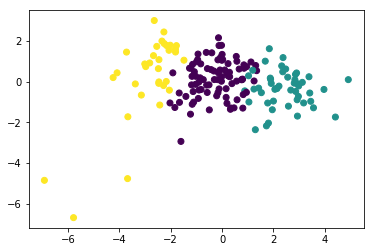

In [27]:
#The cluster membership is added as a separate column “cluster”. Now, we will plot the scatterplot of PC1 vs PC2 and color code them by cluster membership.
## Scatterplot of first 2 PCs, color coded by cluster membership. 
plt.scatter(PCs[:, 0], PCs[:, 1],c= x_z['cluster']) 

In [28]:
#The PCA clearly separates the three clusters that we found via the k-means clustering (as shown in the fig by different colors).

#Now, lets look at the characteristics of each cluster by calculating means of each clusters.
##Add the cluster membership to first dataframe x
ngo1['cluster_ID'] = cluster[:]
print(ngo1.tail())
## Sort the countries in x by cluster membership
x_cluster_sort = ngo1.sort_values('cluster_ID')

     child_mort  exports  health  imports  income  inflation  life_expec  \
162        29.2     46.6    5.25     52.7    2950       2.62        63.0   
163        17.1     28.5    4.91     17.6   16500      45.90        75.4   
164        23.3     72.0    6.84     80.2    4490      12.10        73.1   
165        56.3     30.0    5.18     34.4    4480      23.60        67.5   
166        83.1     37.0    5.89     30.9    3280      14.00        52.0   

     total_fer   gdpp  cluster_ID  
162       3.50   2970           0  
163       2.47  13500           0  
164       1.95   1310           0  
165       4.67   1310           1  
166       5.40   1460           1  


In [29]:
type(x_cluster_sort)
pd.core.frame.DataFrame

pandas.core.frame.DataFrame

In [30]:
## separate countries  based on cluster membership
cluster1 = x_cluster_sort.loc[x_cluster_sort["cluster_ID"] == 0]
cluster2 = x_cluster_sort.loc[x_cluster_sort["cluster_ID"] == 1]
cluster3 = x_cluster_sort.loc[x_cluster_sort["cluster_ID"] == 2]

In [ ]:
#export data for analysis the countries
cluster1.to_csv("cluster1.csv")
cluster2.to_csv("cluster2.csv")
cluster3.to_csv("cluster3.csv")


In [31]:
#calculate mean values for each clusters
c1means = pd.DataFrame(cluster1.mean())
c2means = pd.DataFrame(cluster2.mean())
c3means = pd.DataFrame(cluster3.mean())
print(c1means)

                       0
child_mort     20.897674
exports        41.576512
health          6.274419
imports        48.402326
income      13100.581395
inflation       7.471174
life_expec     73.037209
total_fer       2.281860
gdpp         7014.813953
cluster_ID      0.000000


In [32]:
##Concatenate the three dataframes along axis =1 using the index from c1means
summary = pd.concat([c1means, c2means, c3means], axis=1, join_axes = [c1means.index])


In [33]:
## Assign column names to the dataframe summary
summary.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3']
print(summary)

               Cluster_1    Cluster_2     Cluster_3
child_mort     20.897674    92.366667      4.857576
exports        41.576512    28.546229     58.163636
health          6.274419     6.296458      8.981515
imports        48.402326    41.443040     50.872727
income      13100.581395  3937.770833  46893.939394
inflation       7.471174    11.915938      2.578182
life_expec     73.037209    59.345833     80.393939
total_fer       2.281860     4.953958      1.766061
gdpp         7014.813953  1902.916667  44557.575758
cluster_ID      0.000000     1.000000      2.000000


In [34]:
#In the above table, we have tabulated three clusters that we identified by k-means clustering with their means for respective variables.
#From the table, looking at the mean values for each features, we can say that Cluster 2 are the most poor countries interm of income,GDPP,high child mortality followed by cluster 1 and cluster 3.Cluster 3 is  most richest counties based on all metrics. Cluster 1 are far better country on child_mort, export, Health, income, and inflation  than Cluster 2 but,cluster 2 is slightly better in
#total_fer factor.

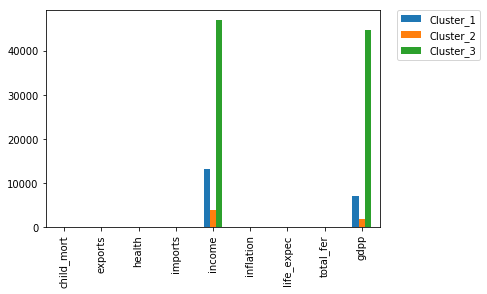

In [35]:
plt.figure()
summary1= summary[:9]
summary1.plot(kind ='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) ## to move the legend outside of plot
plt.show()

In [36]:
#Hierarchical Clustering
y = ngo1
## Standardize the variables.
def standardization_f(y):
    y_bar = np.mean(y)
    s = np.std(y)
    y_z = (y - y_bar) / s
    return(y_z)
print(y.corr())
y_z = y.apply(standardization_f, broadcast = True)
y_z.head()


            child_mort   exports    health   imports    income  inflation  \
child_mort    1.000000 -0.318093 -0.200402 -0.127211 -0.524315   0.288276   
exports      -0.318093  1.000000 -0.114408  0.737381  0.516784  -0.107294   
health       -0.200402 -0.114408  1.000000  0.095717  0.129579  -0.255376   
imports      -0.127211  0.737381  0.095717  1.000000  0.122406  -0.246994   
income       -0.524315  0.516784  0.129579  0.122406  1.000000  -0.147756   
inflation     0.288276 -0.107294 -0.255376 -0.246994 -0.147756   1.000000   
life_expec   -0.886676  0.316313  0.210692  0.054391  0.611962  -0.239705   
total_fer     0.848478 -0.320011 -0.196674 -0.159048 -0.501840   0.316921   
gdpp         -0.483032  0.418725  0.345966  0.115498  0.895571  -0.221631   
cluster_ID    0.074522  0.146382  0.329907  0.000438  0.529535  -0.105327   

            life_expec  total_fer      gdpp  cluster_ID  
child_mort   -0.886676   0.848478 -0.483032    0.074522  
exports       0.316313  -0.320011  0

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_ID
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,0.405728
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,-0.872699
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,-0.872699
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,0.405728
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,-0.872699


In [37]:
# making sure that the data is in n x p matrix format, where n = observations/individuals, p = features
mat = y_z.as_matrix()

In [38]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
# generate the linkage matrix
Z = linkage(mat, 'average')

In [39]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [40]:
#Cophenetic Correlation Coefficient gives the correlation between actual pairwise distance of all samples to those implied by hierarchical clustering.
#The closer the value is to 1, the better the clustering preserves the original distances. Here, we are calculating that using cophenet() function.
c, coph_dists = cophenet(Z, pdist(mat))
c
#Average linkage provides the most highest c value than single, ward and complete.

0.8668632441829562

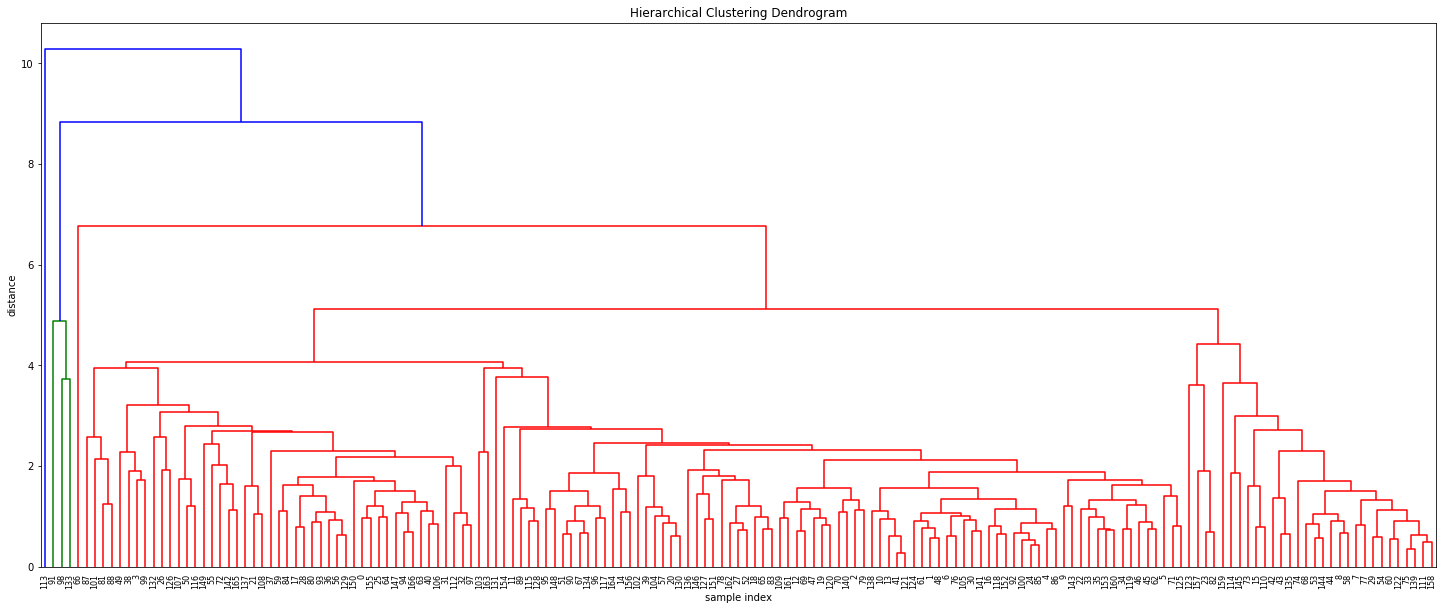

In [41]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [42]:
## From visual inspection, the cutoff distance is set at 4
max_d = 4
def fancy_dendrogram(*args, **kwargs):
  
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

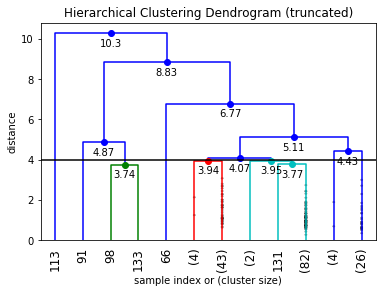

In [43]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=3,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [44]:
## Retrieving the clusters
from scipy.cluster.hierarchy import fcluster
max_d = 4
clusters_id = fcluster(Z, max_d, criterion='distance')
clusters_id

array([3, 4, 4, 3, 4, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 6, 4, 3, 4, 4, 4, 3,
       4, 5, 4, 3, 3, 4, 3, 6, 4, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 4, 6, 6,
       6, 4, 4, 4, 4, 3, 3, 4, 4, 6, 6, 3, 3, 4, 6, 3, 6, 4, 4, 3, 3, 4,
       7, 4, 6, 4, 4, 4, 3, 6, 6, 6, 4, 6, 4, 4, 3, 3, 5, 4, 3, 4, 4, 3,
       3, 4, 4, 2, 4, 3, 3, 4, 4, 3, 1, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 4,
       6, 6, 3, 8, 6, 4, 3, 4, 4, 4, 4, 4, 6, 5, 4, 4, 3, 4, 4, 3, 4, 4,
       3, 1, 4, 6, 4, 3, 4, 6, 4, 4, 3, 4, 6, 6, 4, 3, 4, 3, 3, 4, 4, 4,
       4, 3, 4, 5, 6, 6, 4, 4, 4, 4, 4, 3, 3], dtype=int32)

In [45]:
#Add the cluster membership to first dataframe x
y['cluster_id'] = clusters_id[:]
## Sort the countries in x by cluster membership
y_cluster_sort = y.sort_values('cluster_id')
#del y_cluster_sort['clusters_id'] 
print(y_cluster_sort.tail())

     child_mort  exports  health  imports  income  inflation  life_expec  \
58          4.2     42.3   11.60     37.1   40400      0.758        80.1   
77          3.2     15.0    9.49     13.6   35800     -1.900        82.8   
110         4.5     72.0   11.90     63.6   45500      0.848        80.7   
66        208.0     15.3    6.91     64.7    1500      5.450        32.1   
113       130.0     25.3    5.07     17.4    5150    104.000        60.5   

     total_fer   gdpp  cluster_ID  cluster_id  
58        1.39  41800           2           6  
77        1.39  44500           2           6  
110       1.79  50300           2           6  
66        3.33    662           1           7  
113       5.84   2330           1           8  


In [46]:
## separate countries  based on cluster membership
c1 = y_cluster_sort.loc[y_cluster_sort["cluster_id"] == 1]
c2 = y_cluster_sort.loc[y_cluster_sort["cluster_id"] == 2]
c3 = y_cluster_sort.loc[y_cluster_sort["cluster_id"] == 3]
c4 = y_cluster_sort.loc[y_cluster_sort["cluster_id"] == 4]
c5 = y_cluster_sort.loc[y_cluster_sort["cluster_id"] == 5]

In [ ]:
#import data for analysis for countries
c1.to_csv("c1.csv")
c2.to_csv("c2.csv")
c3.to_csv("c3.csv")
c4.to_csv("c4.csv")
c5.to_csv("c5.csv")

In [47]:
c1_m = pd.DataFrame(c1.mean())
c2_m = pd.DataFrame(c2.mean())
c3_m = pd.DataFrame(c3.mean())
c4_m = pd.DataFrame(c4.mean())
c5_m = pd.DataFrame(c5.mean())
print(c4)

     child_mort  exports  health  imports  income  inflation  life_expec  \
10         13.8    35.00    7.89     43.7   22900     -0.393        73.8   
125        10.0    29.20    5.08     21.1   23100     14.200        69.2   
124        11.5    32.60    5.58     38.8   17800      3.530        73.7   
121         6.0    40.10    7.46     42.1   21800      1.660        76.3   
120        31.9    34.80    3.61     36.6    5600      4.220        69.0   
119        20.3    27.80    5.08     23.8    9960      5.710        77.9   
118        24.1    55.10    5.87     51.5    7290      6.100        74.1   
16         18.8    58.20    5.20     57.5    7880      1.140        71.4   
14          5.5    51.40    5.61     64.5   16200     15.100        70.4   
117        19.7    70.00    8.10     78.2   15400      2.590        77.8   
11          8.6    69.50    4.97     50.9   41100      7.440        76.0   
127        18.9    29.20    6.47     53.1    5400      1.720        71.5   
103        2

In [48]:
#Scaling of data
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
ss = StandardScaler()
ss.fit_transform(ngo1)

array([[ 1.29153238, -1.13827979,  0.27908825, ..., -0.67917961,
         0.40572844, -0.95371034],
       [-0.5389489 , -0.47965843, -0.09701618, ..., -0.48562324,
        -0.8726989 , -0.04359819],
       [-0.27283273, -0.09912164, -0.96607302, ..., -0.46537561,
        -0.8726989 , -0.04359819],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ..., -0.63775406,
        -0.8726989 , -0.04359819],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.63775406,
         0.40572844, -0.95371034],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -0.62954556,
         0.40572844, -0.95371034]])

In [49]:
##Concatenate the six dataframes along axis =1 using the index from c1means
summary_hc = pd.concat([c1_m, c2_m, c3_m, c4_m, c5_m], axis=1, join_axes = [c1_m.index])


In [50]:
## Assign column names to the dataframe summary
summary_hc.columns = ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
print(summary_hc)

            cluster_1  cluster_2    cluster_3     cluster_4   cluster_5
child_mort      4.800       2.80    87.991489     20.672941      9.7250
exports       176.500     175.00    28.789766     41.789176     68.5250
health          6.305       7.77     6.477660      6.181176      2.7350
imports       164.000     142.00    42.301402     48.018824     36.4500
income      50200.000   91700.00  3951.127660  13215.411765  84600.0000
inflation       1.892       3.62     9.921596      7.514365     11.8450
life_expec     81.500      81.30    60.029787     73.127059     77.8250
total_fer       1.255       1.63     4.937872      2.268000      1.9975
gdpp        33850.000  105000.00  1940.595745   7063.694118  44775.0000
cluster_ID      2.000       2.00     0.978723      0.000000      2.0000
cluster_id      1.000       2.00     3.000000      4.000000      5.0000


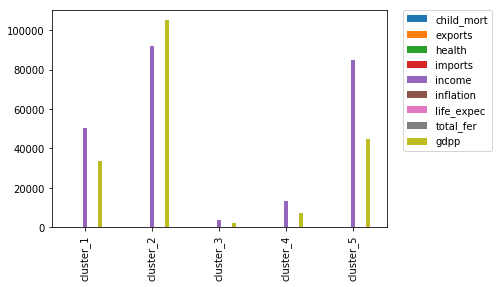

In [51]:
#Now, lets plot a bar graph using these mean values for each clusters
summary_hc1 = summary_hc[:9]
summary_hc2 = summary_hc1.transpose()
plt.figure()
summary_hc2.plot(kind ='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) ## to move the legend outside of plot
plt.show()

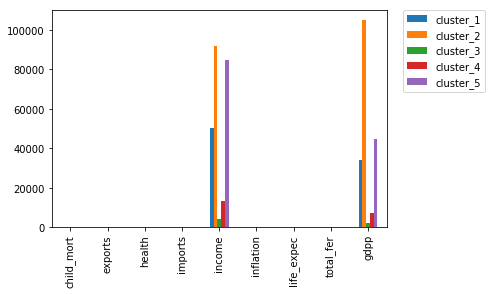

In [52]:
plt.figure()
summary_hc1.plot(kind ='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) ## to move the legend outside of plot
plt.show()

In [ ]:
#Conclusions based on hierarchical clustering
#Cluster 3 are mostly poor countries with low GDP, low income & low life_expec & health & high child_mortality.
## but they are happy in terms of total_fer.

#Cluster4 are developing countries.They have  better income and GDP & life_expec & health & low child mortality rate than cluster 3.

#Cluster 1 are the  better countries with higher GDP, higher income,life_expec & lower child_mort than cluster3 & cluster4.

#Cluster 5 are  far better countries with higher GDP, higher income,life_expec,low child_mort, than cluster1,cluster3 and cluster4.
#Cluster 2 are the best countries with higher GDP, higher income,life_expec,lowest child_mort in contrast of all factors.

#Countries are analysises based on the clusters and  factor variables and mapped in to the countries.
